<center> <h1> SEMINARSKI RAD </h1>
<h1> Primjena multimodalnog učenja za predviđanje bolesti pluća </h1></center>

**Link na podatke:** https://www.kaggle.com/nih-chest-xrays/data

**Članovi grupe:** David Živaljić, Ante Barbarić, Margarita Grašo

Odabrani skup podataka sadrži brojne rendgenske slike pluća zajedno s procijenjenim dijagnozama (14 mogućih bolesti i mogućnost da nemamo uočenih bolesti) te podacima o dobi i spolu promatranog pacijenta. Ovakvi su podaci prikladni za korištenje multimodalnog učenja za predviđanje bolesti zato što prilikom treniranja možemo koristiti rendgenski snimak kao slikovnu komponentu, numeričku varijablu dob te kategoričku varijablu spol. S obzirom da su dijagnoze skupovi koji sadrže potencijalno više bolesti koje su uočene kod pacijenta, koristit ćemo multilabel klasifikaciju.

In [ ]:
#@title import potrebnih biblioteka/metoda

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from glob import glob
import cv2 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
# za neuronsku mrezu
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

import tensorflow as tf

from tensorflow.keras.applications import VGG16
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

!pip install -U tensorflow-addons
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 5.0 MB/s 


# Učitavanje i uvid u podatke

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip -q gdrive/MyDrive/archive-2.zip

In [ ]:
podaci = pd.read_csv('sample_labels.csv')

In [ ]:
# u ovom datasetu sljedece slike koje izbacujemo su crno bijele za razliku od ostalih sto nam stvara grešku prilikom treniranja
triba_izbacit_redove=[13,14,36,58,65,232,419,447,488,528,843,1052,1144,1171,1220,1271,1305,1397,1414,2414,2654,2882,5464]
podaci=podaci.drop(triba_izbacit_redove,axis=0)

Prikaz tekstualnih podataka i slika

In [ ]:
podaci[5:20]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
5,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168000,0.168000
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139000,0.139000
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139000,0.139000
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143000,0.143000
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139000,0.139000
10,00000061_025.png,Consolidation|Effusion|Infiltration|Nodule,25,61,077Y,M,AP,3056,2544,0.139000,0.139000
11,00000079_000.png,Mass,0,79,063Y,M,PA,2500,2048,0.168000,0.168000
12,00000080_005.png,No Finding,5,80,067Y,F,PA,1884,2021,0.194311,0.194311
15,00000096_006.png,Effusion,6,96,067Y,F,PA,2242,2546,0.143000,0.143000
16,00000099_003.png,Effusion,3,99,056Y,F,PA,2830,2801,0.143000,0.143000


In [ ]:
len(podaci)

5583

In [ ]:
folder_path='/content/sample/sample/images/'
slike_fnames = glob(f'{folder_path}*.png')
print([x.split('/')[-1] for x in slike_fnames][500:530])

['00026810_011.png', '00006875_008.png', '00004682_003.png', '00012722_006.png', '00000531_005.png', '00001501_008.png', '00017714_026.png', '00023008_000.png', '00016410_039.png', '00020060_008.png', '00024611_000.png', '00007976_000.png', '00013205_004.png', '00028770_000.png', '00015605_056.png', '00012054_000.png', '00029563_001.png', '00008566_009.png', '00011395_000.png', '00006787_000.png', '00027415_079.png', '00025234_000.png', '00012648_004.png', '00012364_003.png', '00014355_004.png', '00009437_006.png', '00025640_002.png', '00001968_000.png', '00016034_000.png', '00014879_005.png']


In [ ]:
print(len(slike_fnames))

5606


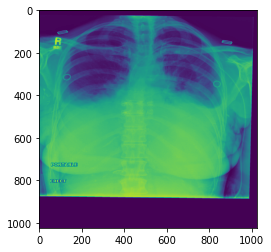

In [ ]:
from PIL import Image
image_directory="/content/sample/sample/images/"
image = Image.open(image_directory +podaci['Image Index'][17])
image.show()
plt.imshow(image)

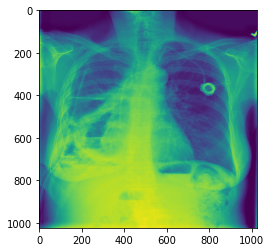

In [ ]:
image = Image.open(slike_fnames[2])
#image.show()
plt.imshow(image)

# Priprema podataka za treniranje

In [ ]:
diseases={
'Atelectasis':0,
'Consolidation':1,
'Infiltration':2,
'Pneumothorax':3,
'Edema':4,
'Emphysema':5,
'Fibrosis':6,
'Effusion':7,
'Pneumonia':8,
'Pleural_Thickening':9,
'Cardiomegaly':10,
'Nodule':11,
'Mass':12,
'Hernia':13,
'No Finding':14}

In [ ]:
def fja(ulaz):
  rez=[]
  for x in ulaz['Image Index']:
    
    t=[0]*15
    for el in ulaz[ulaz['Image Index']==x]['Finding Labels'].to_numpy()[0].split('|'):
        t[diseases[el]]=1
    
    rez.append(t)
  return rez


In [ ]:
train_podaci,test_podaci=train_test_split(podaci, random_state=20, test_size=0.4)

In [ ]:
print(train_podaci.size)
print(test_podaci.size)

36839
24574


In [ ]:
y_train=fja(train_podaci)
y_test=fja(test_podaci)

In [ ]:
y_train=np.array(y_train)
y_test=np.array(y_test)


In [ ]:
test_podaci['Patient Age']=[int(i[1:3]) for i in test_podaci['Patient Age'].to_numpy()]
train_podaci['Patient Age']=[int(i[1:3]) for i in train_podaci['Patient Age'].to_numpy()]
podaci['Patient Age']=[int(i[1:3]) for i in podaci['Patient Age'].to_numpy()]



In [ ]:
MAX=max([int(i) for i in podaci['Patient Age']])
rez_c=[int(i)/MAX for i in train_podaci['Patient Age']]
len(rez_c)

3349

In [ ]:
train_podaci.size

36839

In [ ]:
def year_and_gender_2(df,ulaz):
  #kontinuirane varijable prvo
  MAX=max([int(i) for i in df['Patient Age']])
  rez_c=[int(i)/MAX for i in ulaz['Patient Age']]
  #kategoricke
  aa={'M':0,'F':1}
  rez_k=[aa[i] for i in ulaz['Patient Gender']]
  ##spajanje
  rez=[]
  for i in range(ulaz['Patient Gender'].size):
    rez.append([rez_c[i],rez_k[i]])
    
  return np.array(rez)

In [ ]:
train_att=year_and_gender_2(podaci,train_podaci)
test_att=year_and_gender_2(podaci,test_podaci)

In [ ]:
len(train_att)

3349

In [ ]:
np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)
np.save("train_att.npy", train_att)
np.save("test_att.npy", test_att)

# Priprema slika

In [ ]:
from keras.preprocessing import image
SIZE = 224
image_directory="/content/sample/sample/images/"
X_dataset = []  
for el in train_podaci['Image Index']:
    img =  image.load_img(image_directory+el, target_size=(SIZE,SIZE,3))
    img = np.array(img.getdata())
    img = np.asarray(img, dtype = 'float32') / 255.
    X_dataset.append(img)
    
X = np.array(X_dataset)

In [ ]:
train_slike_VGG=[]
for el in X:
  train_slike_VGG.append(el.reshape(224,224,3))

In [ ]:
SIZE = 224
image_directory="/content/sample/sample/images/"
X_dataset = []  
for el in test_podaci['Image Index']:
    img =  image.load_img(image_directory+el, target_size=(SIZE,SIZE,3))
    img = np.array(img.getdata())
    img = np.asarray(img, dtype = 'float32') / 255.
    X_dataset.append(img)
    
X = np.array(X_dataset)
test_slike_VGG=[]
for el in X:
  test_slike_VGG.append(el.reshape(224,224,3))

In [ ]:
train_slike_VGG=np.array(train_slike_VGG)
test_slike_VGG=np.array(test_slike_VGG)

In [ ]:
np.save("train_slike_VGG.npy", train_slike_VGG)
np.save("test_slike_VGG.npy", test_slike_VGG)

 # **Početni model neuronske mreže**

# Treniranje i spremanje modela

In [ ]:
# Model za slike
def Model_1():
  model = Sequential()

  model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(224,224,3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(15, activation='relu'))

  return model


In [ ]:
model=Model_1()
model.summary()

In [ ]:
# Model za tekstualne podatke
def Model_2(dim2):
  model_2=Sequential()
  model_2.add(Dense(128,input_dim=dim2,activation='relu'))
  model_2.add(Dense(64,activation='relu'))
  model_2.add(Dense(32,activation='relu'))
  model_2.add(Dense(15,activation='relu'))
  return model_2

In [ ]:
# Spajanje modela
model_2=Model_2(2)
combined_input=concatenate([model_2.output,model.output])

x=Dense(30,activation='relu')(combined_input)
x=Dense(15,activation='sigmoid')(x)

final_model=Model(inputs=[model_2.input,model.input],outputs=x)

In [ ]:
plot_model(final_model)

Kreirali smo neuronsku mrežu koja sadrži dvije neuronske mreže. Prva neuronska mreža sadrži konvolucijske slojeve koju su nam potrebni za učenje na slikama, dok druga neuronska mreža služi za predviđanje na temelju tekstualnih podataka pa sadrži samo potpuno povezane slojeve.

In [ ]:
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy',tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TruePositives()])

In [ ]:
history = final_model.fit(x=[train_att,train_slike_VGG], y=y_train, epochs=10, validation_split=0.2, batch_size=64)

Epoch 1/10
42/42 [==============================] - 20s 173ms/step - loss: 0.4376 - binary_accuracy: 0.7997 - false_negatives: 2377.0000 - true_positives: 915.0000 - val_loss: 0.3177 - val_binary_accuracy: 0.9211 - val_false_negatives: 483.0000 - val_true_positives: 369.0000
Epoch 2/10
42/42 [==============================] - 4s 106ms/step - loss: 0.2512 - binary_accuracy: 0.9205 - false_negatives: 2177.0000 - true_positives: 1115.0000 - val_loss: 0.2309 - val_binary_accuracy: 0.9220 - val_false_negatives: 483.0000 - val_true_positives: 369.0000
Epoch 3/10
42/42 [==============================] - 4s 104ms/step - loss: 0.2184 - binary_accuracy: 0.9233 - false_negatives: 2224.0000 - true_positives: 1068.0000 - val_loss: 0.2181 - val_binary_accuracy: 0.9220 - val_false_negatives: 483.0000 - val_true_positives: 369.0000
Epoch 4/10
42/42 [==============================] - 4s 103ms/step - loss: 0.2139 - binary_accuracy: 0.9253 - false_negatives: 2220.0000 - true_positives: 1072.0000 - val_lo

In [ ]:
# Spremanje natreniranog modela
final_model.save('multi_modal.h5')

In [ ]:
np.save('history.npy',history.history)

# Učitavanje modela i ispitivanje točnosti

In [ ]:
# train_slike_VGG = np. load("train_slike_VGG.npy")
# test_slike_VGG = np. load("test_slike_VGG.npy")
# y_train = np.load("y_train.npy")
# y_test = np.load("y_test.npy")
# train_att = np.load("train_att.npy")
# test_att = np.load("test_att.npy")

In [ ]:
final_model = tf.keras.models.load_model('multi_modal.h5')

In [ ]:
_,acc,_,_ = final_model.evaluate([test_att,test_slike_VGG], y_test)

70/70 [==============================] - 13s 41ms/step - loss: 0.2119 - binary_accuracy: 0.9273 - false_negatives: 1921.0000 - true_positives: 884.0000


In [ ]:
print('Točnost modela: ',(acc*100.0),"%")

Točnost modela:  92.73350238800049 %


In [ ]:
predict=final_model.predict([test_att,test_slike_VGG])

In [ ]:
print('Izlaz:',np.round(predict[12],2))
print('Predviđane labele:',np.round(predict[12]))
print('Stvarne labele:',y_test[12])

Izlaz: [0.09 0.04 0.16 0.05 0.02 0.02 0.02 0.1  0.01 0.03 0.03 0.06 0.06 0.
 0.55]
Predviđane labele: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Stvarne labele: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


In [ ]:
metric = tfa.metrics.MultiLabelConfusionMatrix(num_classes=15)
metric.update_state(y_test, np.round(predict))
result = metric.result()
print('Matrica konfuzije')
print(sum(result.numpy()))

Matrica konfuzije
[[30191.   514.]
 [ 1921.   884.]]


Iz gornje matrice konfuzije vidimo da imamo dosta false negativnih, što nije dobro s obzirom da se bavimo problemom detekcije bolesti. Da bismo bolje uočili u čemu je točno problem, izbacit ćemo predviđanje labele 'No findings' jer ona ne predstavlja jednu od bolesti.

<img alt= 'matrica konfuzije' src = 'https://www.nbshare.io/static/snapshots/cm_colored_1-min.png' width = '70%'>

# Priprema labela za treniranje bez 'No findings'

In [ ]:
def fja2(ulaz):
  rez=[]
  for y in ulaz:
    rez.append(y[:-1])
  return rez


In [ ]:
y_train_2 = fja2(y_train)
y_test_2 = fja2(y_test)

In [ ]:
y_train_2 = np.array(y_train_2)
y_test_2 = np.array(y_test_2)

In [ ]:
np.save("y_train_2.npy", y_train_2)
np.save("y_test_2.npy", y_test_2)

# Usporedimo sada prethodne dvije matrice konfuzije:

In [ ]:
no_find = 0
no_find_i_bolest = 0
for x in y_test:
  if x[14]==1:
    no_find = no_find+1
    if sum(x)>1:
      no_find_i_bolest=no_find_i_bolest+1
print('Ukupan broj slučaja s no_findings', no_find)
print('Od toga oni koji imaju još neku bolest', no_find_i_bolest)

Ukupan broj slučaja s no_findings 1188
Od toga oni koji imaju još neku bolest 0


In [ ]:
predict_no_find = []
for i in range (len(predict)):
  predict_no_find.append(predict[i][:-1])

In [ ]:
print('Originalna matrica konfuzija')
print(sum(result.numpy()))

Originalna matrica konfuzija
[[30191.   514.]
 [ 1921.   884.]]


In [ ]:
metric_1 = tfa.metrics.MultiLabelConfusionMatrix(num_classes=14)
metric_1.update_state(y_test_2, np.round(predict_no_find))
result_1 = metric_1.result()
print('Matrica konfuzija bez labele no_findings')
print(sum(result_1.numpy()))

Matrica konfuzija bez labele no_findings
[[29659.     0.]
 [ 1617.     0.]]


In [ ]:
print('broj slučajeva koji imaju neke bolesti: ',len(predict)-no_find)

broj slučajeva koji imaju neke bolesti:  1046


Možemo zaključiti da neuronska mreža nekad za no_findings predvidi false negativno, nekad false_pozitivno, a nekada točno. Za slučajeve kada osoba ima neke bolesti imamo jako puno false negativnih rezultata obzirom na ukupni broj takvih osoba, što je vrlo loše jer neuronska mreža ne primijeti bolest iako ona postoji. Želimo naći model koji je više osjetljiv na potencijalne bolesti.

# Početni model uz optimizaciju broja false negativnih

# Treniranje i spremanje modela

In [ ]:
# Model za slike
def Model_1_2():
  model = Sequential()

  model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(224,224,3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(15, activation='relu'))

  return model


In [ ]:
model_1_2=Model_1_2()

In [ ]:
# Model za tekstualne podatke
def Model_2_2(dim2):
  model_2=Sequential()
  model_2.add(Dense(128,input_dim=dim2,activation='relu'))
  model_2.add(Dense(64,activation='relu'))
  model_2.add(Dense(32,activation='relu'))
  model_2.add(Dense(15,activation='relu'))
  return model_2

In [ ]:
# Spajanje modela
model_2_2=Model_2_2(2)
combined_input=concatenate([model_2_2.output,model_1_2.output])

x=Dense(30,activation='relu')(combined_input)
x=Dense(15,activation='sigmoid')(x)

final_model_1_2=Model(inputs=[model_2_2.input,model_1_2.input],outputs=x)

In [ ]:
final_model_1_2.compile(optimizer='adam', loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=10.0), metrics=['binary_accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TruePositives()])

In [ ]:
# tf.config.run_functions_eagerly(True)

In [ ]:
history_1_2 = final_model_1_2.fit(x=[train_att,train_slike_VGG], y=y_train, epochs=10, validation_split=0.2, batch_size=64)

Epoch 1/10
42/42 [==============================] - 11s 197ms/step - loss: 0.0042 - binary_accuracy: 0.5998 - false_negatives_2: 1739.0000 - true_positives_2: 1553.0000 - val_loss: 5.9131e-04 - val_binary_accuracy: 0.8677 - val_false_negatives_2: 773.0000 - val_true_positives_2: 79.0000
Epoch 2/10
42/42 [==============================] - 7s 174ms/step - loss: 7.4623e-04 - binary_accuracy: 0.7449 - false_negatives_2: 2365.0000 - true_positives_2: 927.0000 - val_loss: 5.2668e-04 - val_binary_accuracy: 0.8868 - val_false_negatives_2: 772.0000 - val_true_positives_2: 80.0000
Epoch 3/10
42/42 [==============================] - 7s 176ms/step - loss: 5.4521e-04 - binary_accuracy: 0.8350 - false_negatives_2: 2740.0000 - true_positives_2: 552.0000 - val_loss: 4.5473e-04 - val_binary_accuracy: 0.9052 - val_false_negatives_2: 840.0000 - val_true_positives_2: 12.0000
Epoch 4/10
42/42 [==============================] - 7s 174ms/step - loss: 4.4058e-04 - binary_accuracy: 0.8773 - false_negatives_2: 

In [ ]:
# Spremanje natreniranog modela
final_model_1_2.save('multi_modal_2.h5')

In [ ]:
np.save('history_1_2.npy',history_1_2.history)

In [ ]:
def plot_history(hist_baseline, br_epoha, hist_FC = None):
    
    fig = plt.figure(figsize = (17,5))
    metrics = ['loss', 'binary_accuracy']
    
    for i in range(len(metrics)):
        metric = metrics[i]
        plt.subplot(1, 2, i+1)
        plt.title(metric.capitalize())
        plt.xlabel("epoha")
        plt.ylabel(metric)
        plt.plot(range(1, br_epoha + 1), hist_baseline[metric], 
                 label="train-weighted", color = "tab:blue")
        plt.plot(range(1, br_epoha + 1), hist_baseline['val_' + metric], 
                 label="val-weighted", color = "tab:orange")

        if hist_FC:
            plt.plot(range(1, br_epoha + 1), hist_FC[metric], 
                 label="train", color = "tab:blue", linestyle = '--', alpha = 0.5)
            plt.plot(range(1, br_epoha + 1), hist_FC["val_" + metric], 
                 label="val", color = "tab:orange", linestyle = '--', alpha = 0.5)
        plt.legend()

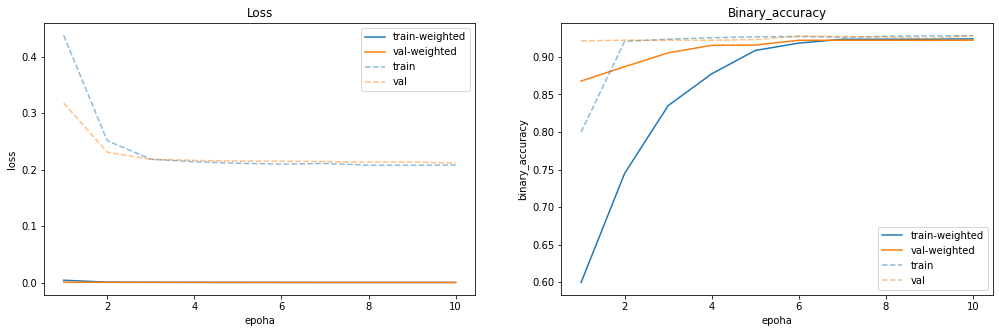

In [ ]:
history = np.load('history.npy',allow_pickle='TRUE').item()
history_1_2 = np.load('history_1_2.npy',allow_pickle='TRUE').item()
plot_history(history_1_2, 10, history)

Možemo primijetiti da točnost relativno brzo prestaje rasti pa bi bilo dobro zaustaviti treniranje u nekoj od ranijih epoha kako ne bi došlo do preteniranja.

# Učitavanje modela i ispitivanje točnosti

In [ ]:

train_slike_VGG = np. load("train_slike_VGG.npy")
test_slike_VGG = np. load("test_slike_VGG.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")
train_att = np.load("train_att.npy")
test_att = np.load("test_att.npy")


In [ ]:
final_model_1_2 = tf.keras.models.load_model('multi_modal_2.h5')

In [ ]:
_,acc,_,_ = final_model_1_2.evaluate([test_att,test_slike_VGG], y_test)

70/70 [==============================] - 15s 52ms/step - loss: 2.7259e-04 - binary_accuracy: 0.9205 - false_negatives_2: 1617.0000 - true_positives_2: 1188.0000


In [ ]:
print('Točnost modela: ',(acc*100.0),"%")

Točnost modela:  92.0531153678894 %


In [ ]:
predict_1_2=final_model_1_2.predict([test_att,test_slike_VGG])

In [ ]:
print('Izlaz:',np.round(predict_1_2[12],2))
print('Predviđane labele:',np.round(predict_1_2[12]))
print('Stvarne labele:',y_test[12])

Izlaz: [0.45 0.42 0.46 0.43 0.41 0.41 0.4  0.46 0.4  0.42 0.41 0.44 0.43 0.36
 0.51]
Predviđane labele: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Stvarne labele: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


In [ ]:
metric_2 = tfa.metrics.MultiLabelConfusionMatrix(num_classes=15)
metric_2.update_state(y_test, np.round(predict_1_2))
result_2 = metric_2.result()
print('Matrica konfuzije')
print(sum(result_2.numpy()))

Matrica konfuzije
[[29659.  1046.]
 [ 1617.  1188.]]


Na ovaj smo način uspjeli malo smanjiti broj false negativnih, ali na uštrb povećanja broja false pozitivnih.

# Početni model uz optimizaciju broja false negativnih sa smanjenim brojem epoha

# Treniranje

In [ ]:
# Model za slike
def Model_2_2():
  model = Sequential()

  model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(224,224,3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(15, activation='relu'))

  return model


In [ ]:
model_2_2=Model_2_2()

In [ ]:
model_text_1 = Sequential([
  Dense(128, input_dim=2, activation='relu'),
  Dense(64, activation='relu'),
  Dense(32,activation='relu'),
  Dense(15,activation='relu')])

In [ ]:
# Spajanje modela
combined_input=concatenate([model_text_1.output, model_2_2.output])

x = Dense(30, activation = 'relu')(combined_input)
x = Dense(30, activation = 'relu')(x)
x = Dense(15, activation = 'sigmoid')(x)

final_model_2_2 = Model(inputs = [model_text_1.input, model_2_2.input], outputs=x)

In [ ]:
final_model_2_2.compile(optimizer='adam', loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=10.0), metrics=['binary_accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TruePositives()])

In [ ]:
# tf.config.run_functions_eagerly(True)

In [ ]:
history_3 = final_model_2_2.fit(x=[train_att,train_slike_VGG], y=y_train, epochs=5, validation_split=0.2, batch_size=64)

Epoch 1/5
42/42 [==============================] - 16s 263ms/step - loss: 0.0011 - binary_accuracy: 0.7459 - false_negatives_1: 1880.0000 - true_positives_1: 1412.0000 - val_loss: 4.8892e-04 - val_binary_accuracy: 0.8960 - val_false_negatives_1: 473.0000 - val_true_positives_1: 379.0000
Epoch 2/5
42/42 [==============================] - 7s 176ms/step - loss: 4.6989e-04 - binary_accuracy: 0.8815 - false_negatives_1: 1995.0000 - true_positives_1: 1297.0000 - val_loss: 3.6769e-04 - val_binary_accuracy: 0.9220 - val_false_negatives_1: 484.0000 - val_true_positives_1: 368.0000
Epoch 3/5
42/42 [==============================] - 7s 174ms/step - loss: 3.5963e-04 - binary_accuracy: 0.9146 - false_negatives_1: 2150.0000 - true_positives_1: 1142.0000 - val_loss: 3.1018e-04 - val_binary_accuracy: 0.9195 - val_false_negatives_1: 564.0000 - val_true_positives_1: 288.0000
Epoch 4/5
42/42 [==============================] - 7s 172ms/step - loss: 3.1344e-04 - binary_accuracy: 0.9200 - false_negatives_1:

In [ ]:
final_model_2_2.save('multi_modal_2_2.h5')

In [ ]:
np.save('history_3.npy',history_3.history)

# Učitavanje modela i ispitivanje točnosti

In [ ]:
train_slike_VGG = np. load("train_slike_VGG.npy")
test_slike_VGG = np. load("test_slike_VGG.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")
train_att = np.load("train_att.npy")
test_att = np.load("test_att.npy")

In [ ]:
final_model_2_2 = tf.keras.models.load_model('multi_modal_2_2.h5')

In [ ]:
_,acc,_,_ = final_model_2_2.evaluate([test_att,test_slike_VGG], y_test)

70/70 [==============================] - 3s 36ms/step - loss: 2.7667e-04 - binary_accuracy: 0.9205 - false_negatives_1: 1617.0000 - true_positives_1: 1188.0000


In [ ]:
print('Točnost modela: ',(acc*100.0),"%")

Točnost modela:  92.0531153678894 %


Točnost se nije smanjila iako smo smanjili broj epoha.

In [ ]:
predict_2=final_model_2_2.predict([test_att,test_slike_VGG])

In [ ]:
print('Izlaz:',np.round(predict_2[12],2))
print('Predviđane labele:',np.round(predict_2[12]))
print('Stvarne labele:',y_test[12])

Izlaz: [0.44 0.41 0.46 0.43 0.4  0.4  0.4  0.45 0.41 0.41 0.4  0.43 0.42 0.38
 0.51]
Predviđane labele: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Stvarne labele: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


In [ ]:
metric_5 = tfa.metrics.MultiLabelConfusionMatrix(num_classes=15)
metric_5.update_state(y_test, np.round(predict_2))
result_5 = metric_5.result()
print('Matrica konfuzije')
print(sum(result_5.numpy()))

Matrica konfuzije
[[29659.  1046.]
 [ 1617.  1188.]]


Dobili smo slične rezultate kao i s većim brojem epoha.

# **VGG model - transfer learning**


# Treniranje

In [ ]:
VGG_model =  VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 

In [ ]:
VGG_model.trainable = False

In [ ]:
VGG_model.trainable = True

set_trainable = False
for layer in VGG_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model_VGG = Sequential([
     VGG_model,
     Flatten(),
     Dense(256, activation='relu'),
     Dense(128, activation='relu'),
     Dense(15, activation='relu')])

In [ ]:
model_text = Sequential([
  Dense(128, input_dim=2, activation='relu'),
  Dense(64, activation='relu'),
  Dense(32,activation='relu'),
  Dense(15,activation='relu')])

In [ ]:
# Spajanje modela
combined_input=concatenate([model_text.output, model_VGG.output])

x = Dense(30, activation = 'relu')(combined_input)
x = Dense(30, activation = 'relu')(x)
x = Dense(15, activation = 'sigmoid')(x)

final_model_VGG = Model(inputs = [model_text.input, model_VGG.input], outputs=x)

In [ ]:
final_model_VGG.compile(optimizer='adam', loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=10.0), metrics=['binary_accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TruePositives()])

In [ ]:
# tf.config.run_functions_eagerly(True)

In [ ]:
history_2 = final_model_VGG.fit(x=[train_att,train_slike_VGG], y=y_train, epochs=10, validation_split=0.2, batch_size=64)

Epoch 1/10
42/42 [==============================] - 35s 769ms/step - loss: 4.8318e-04 - binary_accuracy: 0.8159 - false_negatives_2: 1784.0000 - true_positives_2: 1508.0000 - val_loss: 3.0992e-04 - val_binary_accuracy: 0.9224 - val_false_negatives_2: 607.0000 - val_true_positives_2: 245.0000
Epoch 2/10
42/42 [==============================] - 31s 747ms/step - loss: 2.8750e-04 - binary_accuracy: 0.9242 - false_negatives_2: 2180.0000 - true_positives_2: 1112.0000 - val_loss: 2.7201e-04 - val_binary_accuracy: 0.9220 - val_false_negatives_2: 483.0000 - val_true_positives_2: 369.0000
Epoch 3/10
42/42 [==============================] - 31s 749ms/step - loss: 2.6961e-04 - binary_accuracy: 0.9246 - false_negatives_2: 1982.0000 - true_positives_2: 1310.0000 - val_loss: 2.6938e-04 - val_binary_accuracy: 0.9152 - val_false_negatives_2: 852.0000 - val_true_positives_2: 0.0000e+00
Epoch 4/10
42/42 [==============================] - 31s 749ms/step - loss: 2.6629e-04 - binary_accuracy: 0.9244 - false

In [ ]:
final_model_VGG.save('multi_modal_VGG.h5')

In [ ]:
np.save('history_2.npy',history_2.history)

# Učitavanje modela i ispitivanje točnosti

In [ ]:
train_slike_VGG = np. load("train_slike_VGG.npy")
test_slike_VGG = np. load("test_slike_VGG.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")
train_att = np.load("train_att.npy")
test_att = np.load("test_att.npy")

In [ ]:
final_model_VGG = tf.keras.models.load_model('multi_modal_VGG.h5')

In [ ]:
_,acc,_,_ = final_model_VGG.evaluate([test_att,test_slike_VGG], y_test)

70/70 [==============================] - 21s 296ms/step - loss: 2.6091e-04 - binary_accuracy: 0.9289 - false_negatives_2: 1751.0000 - true_positives_2: 1054.0000


In [ ]:
print('Točnost modela: ',(acc*100.0),"%")

Točnost modela:  92.88570284843445 %


In [ ]:
predict_1 = final_model_VGG.predict([test_att,test_slike_VGG])

In [ ]:
print('Izlaz:',np.round(predict_1[12],2))
print('Predviđane labele:',np.round(predict_1[12]))
print('Stvarne labele:',y_test[12])

Izlaz: [0.44 0.39 0.45 0.41 0.38 0.4  0.39 0.42 0.37 0.4  0.39 0.43 0.43 0.35
 0.52]
Predviđane labele: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Stvarne labele: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


In [ ]:
metric_0= tfa.metrics.MultiLabelConfusionMatrix(num_classes=15)
metric_0.update_state(y_test, np.round(predict_1))
result_0 = metric_0.result()
print('Matrica konfuzija')
print(sum(result_0.numpy()))

Matrica konfuzija
[[30072.   633.]
 [ 1751.  1054.]]


Na ovaj način dobili smo slične rezultate kao i s početnim modelom. Dakle, unaprijed natrenirana mreža nam nije donijela značajno poboljšanje.

# Usporedba multimodalnih modela

In [ ]:
def plot_history(hist_baseline, br_epoha, hist_FC = None):
    
    fig = plt.figure(figsize = (17,5))
    metrics = ['loss', 'binary_accuracy']
    
    for i in range(len(metrics)):
        metric = metrics[i]
        plt.subplot(1, 2, i+1)
        plt.title(metric.capitalize())
        plt.xlabel("epoha")
        plt.ylabel(metric)
        plt.plot(range(1, br_epoha + 1), hist_baseline[metric], 
                 label="train CNN", color = "tab:blue")
        plt.plot(range(1, br_epoha + 1), hist_baseline['val_' + metric], 
                 label="val CNN", color = "tab:orange")

        if hist_FC:
            plt.plot(range(1, br_epoha + 1), hist_FC[metric], 
                 label="train VGG", color = "tab:blue", linestyle = '--', alpha = 0.5)
            plt.plot(range(1, br_epoha + 1), hist_FC["val_" + metric], 
                 label="val VGG", color = "tab:orange", linestyle = '--', alpha = 0.5)
        plt.legend()

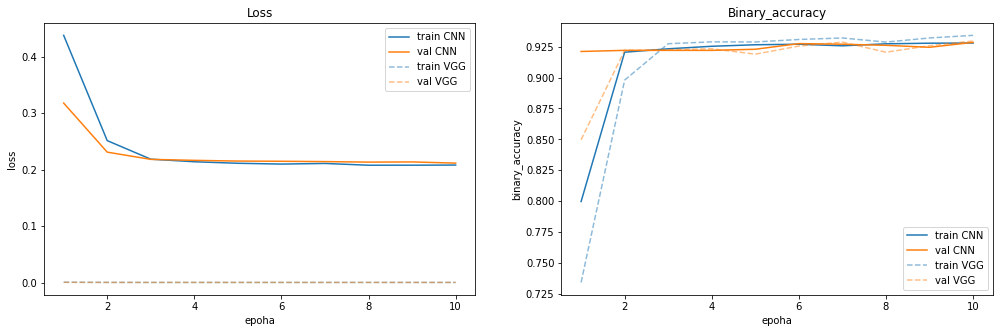

In [ ]:
history = np.load('history.npy',allow_pickle='TRUE').item()
history_2 = np.load('history_2.npy',allow_pickle='TRUE').item()
plot_history(history, 10, history_2)

Iz gornjih grafova možemo zaključiti da nam predtrenirani VGG model nije značajno poboljšao točnost, ali mu je gubitak značajno manji.

# Za sljedeće modele koristit ćemo samo podskup cijelog skupa podataka - izbacit ćemo one podatke koji sadrže No findings

# Prvo ćemo pokušati samo izbaciti labelu koja označava No findings

# Treniranje i spremanje modela

In [ ]:
# Model za slike
def Model_1_3():
  model = Sequential()

  model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(224,224,3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(14, activation='relu'))

  return model


In [ ]:
model_1_3=Model_1_3()

In [ ]:
# Model za tekstualne podatke
def Model_2_3(dim2):
  model_2=Sequential()
  model_2.add(Dense(128,input_dim=dim2,activation='relu'))
  model_2.add(Dense(64,activation='relu'))
  model_2.add(Dense(32,activation='relu'))
  model_2.add(Dense(14,activation='relu'))
  return model_2

In [ ]:
# Spajanje modela
model_2_3=Model_2_3(2)
combined_input=concatenate([model_2_3.output,model_1_3.output])

x=Dense(28,activation='relu')(combined_input)
x=Dense(14,activation='sigmoid')(x)

final_model_1_3=Model(inputs=[model_2_3.input,model_1_3.input],outputs=x)

In [ ]:
final_model_1_3.compile(optimizer='adam', loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=20), metrics=['binary_accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TruePositives()])

In [ ]:
history_1_3 = final_model_1_3.fit(x=[train_att,train_slike_VGG], y=y_train_2, epochs=10, validation_split=0.2, batch_size=64)

Epoch 1/10
42/42 [==============================] - 10s 190ms/step - loss: 2.6635e-06 - binary_accuracy: 0.9492 - false_negatives_1: 1817.0000 - true_positives_1: 7.0000 - val_loss: 4.2461e-07 - val_binary_accuracy: 0.9485 - val_false_negatives_1: 483.0000 - val_true_positives_1: 0.0000e+00
Epoch 2/10
42/42 [==============================] - 7s 174ms/step - loss: 7.9494e-05 - binary_accuracy: 0.9183 - false_negatives_1: 1702.0000 - true_positives_1: 122.0000 - val_loss: 2.8040e-05 - val_binary_accuracy: 0.8994 - val_false_negatives_1: 438.0000 - val_true_positives_1: 45.0000
Epoch 3/10
42/42 [==============================] - 7s 174ms/step - loss: 9.1306e-04 - binary_accuracy: 0.8272 - false_negatives_1: 1509.0000 - true_positives_1: 315.0000 - val_loss: 1.0013e-04 - val_binary_accuracy: 0.6977 - val_false_negatives_1: 347.0000 - val_true_positives_1: 136.0000
Epoch 4/10
42/42 [==============================] - 7s 175ms/step - loss: 1.8419e-04 - binary_accuracy: 0.7883 - false_negative

In [ ]:
# Spremanje natreniranog modela
final_model_1_3.save('multi_modal_1_3.h5')

In [ ]:
np.save('history_1_3.npy',history_1_3.history)

In [ ]:
def plot_history(hist_baseline, br_epoha, hist_FC = None):
    
    fig = plt.figure(figsize = (17,5))
    metrics = ['loss', 'binary_accuracy']
    
    for i in range(len(metrics)):
        metric = metrics[i]
        plt.subplot(1, 2, i+1)
        plt.title(metric.capitalize())
        plt.xlabel("epoha")
        plt.ylabel(metric)
        plt.plot(range(1, br_epoha + 1), hist_baseline[metric], 
                 label="train", color = "tab:blue")
        plt.plot(range(1, br_epoha + 1), hist_baseline['val_' + metric], 
                 label="val", color = "tab:orange")

        if hist_FC:
            plt.plot(range(1, br_epoha + 1), hist_FC[metric], 
                 label="train VGG", color = "tab:blue", linestyle = '--', alpha = 0.5)
            plt.plot(range(1, br_epoha + 1), hist_FC["val_" + metric], 
                 label="val VGG", color = "tab:orange", linestyle = '--', alpha = 0.5)
        plt.legend()

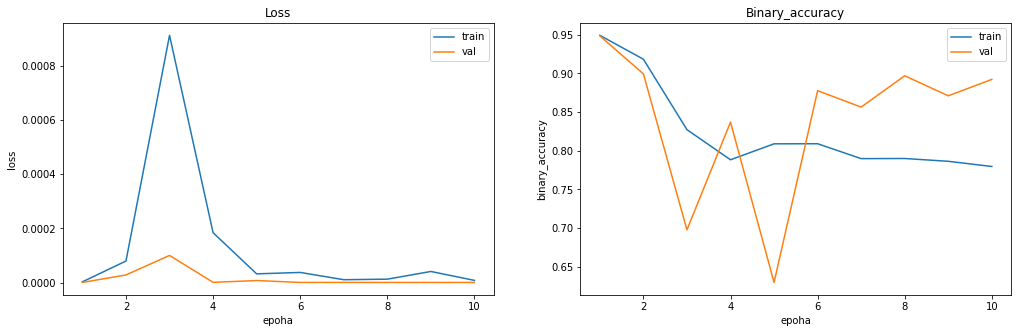

In [ ]:
history_1_3 = np.load('history_1_3.npy',allow_pickle='TRUE').item()
plot_history(history_1_3, 10)

Možemo primijetiti da točnost dosta varira.

# Učitavanje modela i ispitivanje točnosti

In [ ]:
train_slike_VGG = np. load("train_slike_VGG.npy")
test_slike_VGG = np. load("test_slike_VGG.npy")
y_train_2 = np.load("y_train_2.npy")
y_test_2 = np.load("y_test_2.npy")
train_att = np.load("train_att.npy")
test_att = np.load("test_att.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

In [ ]:
final_model_1_3 = tf.keras.models.load_model('multi_modal_1_3.h5')

In [ ]:
_,acc,_,_ = final_model_1_3.evaluate([test_att,test_slike_VGG], y_test_2)

70/70 [==============================] - 15s 44ms/step - loss: 3.6608e-07 - binary_accuracy: 0.8907 - false_negatives_1: 1549.0000 - true_positives_1: 68.0000


In [ ]:
print('Točnost modela: ',(acc*100.0),"%")

Točnost modela:  89.0650987625122 %


In [ ]:
predict_1_3=final_model_1_3.predict([test_att,test_slike_VGG])

In [ ]:
print('Izlaz:',np.round(predict_1_3[12],2))
print('Predviđane labele:',np.round(predict_1_3[12]))
print('Stvarne labele:',y_test_2[12])

Izlaz: [0.5  0.48 0.47 0.49 0.46 0.45 0.42 0.47 0.44 0.48 0.51 0.47 0.47 0.46]
Predviđane labele: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Stvarne labele: [0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
metric_5 = tfa.metrics.MultiLabelConfusionMatrix(num_classes=14)
metric_5.update_state(y_test_2, np.round(predict_1_3))
result_5 = metric_5.result()
print('Matrica konfuzija')
print(sum(result_5.numpy()))

Matrica konfuzija
[[27788.  1871.]
 [ 1549.    68.]]


Uspjeli smo malo smanjiti broj false negativnih, ali smo dobili puno false pozitivnih.

# Sada ćemo pokušati izbaciti cijele podatke koji sadrže No findings

# Priprema podataka - izbacivanje No findings

In [ ]:
ind_train = []

for i in range (len(y_train)):
  if (y_train[i][14] == 1):
    ind_train.append(i)

ind_test = []

for i in range (len(y_test)):
  if (y_test[i][14] == 1):
    ind_test.append(i)

In [ ]:
train_slike_VGG_2 = train_slike_VGG.copy()
train_att_2 = train_att.copy()
y_train_2_2 = y_train_2.copy()

np.delete(train_slike_VGG_2,ind_train)
np.delete(train_att_2,ind_train)
np.delete(y_train_2_2,ind_train)


array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
test_slike_VGG_2 = test_slike_VGG.copy()
test_att_2 = test_att.copy()
y_test_2_2 = y_test_2.copy()

np.delete(test_slike_VGG_2,ind_test)
np.delete(test_att_2,ind_test)
np.delete(y_test_2_2,ind_test)

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
np.save("train_slike_VGG_2.npy", train_slike_VGG_2)
np.save("train_att_2.npy", train_att_2)

np.save("test_slike_VGG_2.npy", test_slike_VGG_2)
np.save("test_att_2.npy", test_att_2)

np.save("y_train_2_2.npy", y_train_2_2)
np.save("y_test_2_2.npy", y_test_2_2)

# Multimodalni model 

# Treniranje

In [ ]:
# Model za slike
def Model_1_4():
  model = Sequential()

  model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(224,224,3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(14, activation='relu'))

  return model

In [ ]:
model_1_4=Model_1_4()

In [ ]:
# Model za tekstualne podatke
def Model_2_3(dim2):
  model_2=Sequential()
  model_2.add(Dense(128,input_dim=dim2,activation='relu'))
  model_2.add(Dense(64,activation='relu'))
  model_2.add(Dense(32,activation='relu'))
  model_2.add(Dense(14,activation='relu'))
  return model_2

In [ ]:
# Spajanje modela
model_text_3=Model_2_3(2)
combined_input=concatenate([model_text_3.output,model_1_4.output])

x = Dense(28,activation='relu')(combined_input)
x = Dense(28,activation='relu')(x)
x = Dense(14,activation='sigmoid')(x)

final_model_6=Model(inputs=[model_text_3.input,model_1_4.input],outputs=x)

In [ ]:
final_model_6.compile(optimizer='adam', loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0), metrics=['binary_accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TruePositives()])

In [ ]:
# tf.config.run_functions_eagerly(True)

In [ ]:
history_4 = final_model_6.fit(x=[train_att_2,train_slike_VGG_2], y=y_train_2_2, epochs=10, validation_split=0.2, batch_size=64)

Epoch 1/10
42/42 [==============================] - 16s 271ms/step - loss: 0.1102 - binary_accuracy: 0.8449 - false_negatives_1: 1552.0000 - true_positives_1: 272.0000 - val_loss: 0.0964 - val_binary_accuracy: 0.9485 - val_false_negatives_1: 483.0000 - val_true_positives_1: 0.0000e+00
Epoch 2/10
42/42 [==============================] - 7s 176ms/step - loss: 0.0648 - binary_accuracy: 0.9490 - false_negatives_1: 1814.0000 - true_positives_1: 10.0000 - val_loss: 0.0610 - val_binary_accuracy: 0.9485 - val_false_negatives_1: 483.0000 - val_true_positives_1: 0.0000e+00
Epoch 3/10
42/42 [==============================] - 7s 175ms/step - loss: 0.0543 - binary_accuracy: 0.9513 - false_negatives_1: 1824.0000 - true_positives_1: 0.0000e+00 - val_loss: 0.0533 - val_binary_accuracy: 0.9485 - val_false_negatives_1: 483.0000 - val_true_positives_1: 0.0000e+00
Epoch 4/10
42/42 [==============================] - 7s 176ms/step - loss: 0.0517 - binary_accuracy: 0.9514 - false_negatives_1: 1824.0000 - tru

In [ ]:
final_model_6.save('multi_modal_6.h5')

In [ ]:
len(train_att_2)*2

6698

# Učitavanje modela i ispitivanje točnosti

In [ ]:
train_slike_VGG_2 = np. load("train_slike_VGG_2.npy")
test_slike_VGG_2 = np. load("test_slike_VGG_2.npy")
y_train_2_2 = np.load("y_train_2_2.npy")
y_test_2_2 = np.load("y_test_2_2.npy")
train_att_2 = np.load("train_att_2.npy")
test_att_2 = np.load("test_att_2.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

In [ ]:
final_model_6 = tf.keras.models.load_model('multi_modal_6.h5')

In [ ]:
_,acc,_,_ = final_model_6.evaluate([test_att_2,test_slike_VGG_2], y_test_2_2)

70/70 [==============================] - 3s 44ms/step - loss: 0.0506 - binary_accuracy: 0.9483 - false_negatives_1: 1617.0000 - true_positives_1: 0.0000e+00


In [ ]:
print('Točnost modela:', (acc*100.0),"%")

Točnost modela: 94.8298990726471 %


In [ ]:
predict_4=final_model_6.predict([test_att_2,test_slike_VGG_2])

In [ ]:
print('Izlaz:',np.round(predict_4[12],2))
print('Predviđane labele:',np.round(predict_4[12]))
print('Stvarne labele:',y_test_2_2[12])

Izlaz: [0.31 0.25 0.36 0.27 0.21 0.22 0.19 0.32 0.19 0.23 0.23 0.28 0.27 0.12]
Predviđane labele: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Stvarne labele: [0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
metric_7 = tfa.metrics.MultiLabelConfusionMatrix(num_classes=14)
metric_7.update_state(y_test_2_2, np.round(predict_4))
result_7 = metric_7.result()
print('Matrica konfuzija')
print(sum(result_7.numpy()))

Matrica konfuzija
[[29659.     0.]
 [ 1617.     0.]]


Nismo uspjeli riješiti problem false negativnih na ovaj način.

# **VGG model samo za slike**

In [ ]:
VGG_model_2 =  VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 

In [ ]:
VGG_model_2.trainable = False

In [ ]:
VGG_model_2.trainable = True

set_trainable = False
for layer in VGG_model_2.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model_VGG_2 = Sequential([
     VGG_model_2,
     Flatten(),
     Dense(256, activation='relu'),
     Dense(128, activation='relu'),
     Dense(14, activation='sigmoid')])


model_VGG_2.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0), 
            optimizer='adam', 
            metrics=['binary_accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TruePositives()])

In [ ]:
history_5 = model_VGG_2.fit(x=train_slike_VGG_2, y=y_train_2_2, epochs=10, validation_split=0.2, batch_size=64)

Epoch 1/10
42/42 [==============================] - 56s 988ms/step - loss: 0.0732 - binary_accuracy: 0.9226 - false_negatives: 1739.0000 - true_positives: 85.0000 - val_loss: 0.0527 - val_binary_accuracy: 0.9485 - val_false_negatives: 483.0000 - val_true_positives: 0.0000e+00
Epoch 2/10
42/42 [==============================] - 32s 770ms/step - loss: 0.0504 - binary_accuracy: 0.9514 - false_negatives: 1824.0000 - true_positives: 0.0000e+00 - val_loss: 0.0578 - val_binary_accuracy: 0.9485 - val_false_negatives: 483.0000 - val_true_positives: 0.0000e+00
Epoch 3/10
42/42 [==============================] - 32s 767ms/step - loss: 0.0506 - binary_accuracy: 0.9514 - false_negatives: 1824.0000 - true_positives: 0.0000e+00 - val_loss: 0.0500 - val_binary_accuracy: 0.9485 - val_false_negatives: 483.0000 - val_true_positives: 0.0000e+00
Epoch 4/10
42/42 [==============================] - 32s 769ms/step - loss: 0.0486 - binary_accuracy: 0.9514 - false_negatives: 1824.0000 - true_positives: 0.0000e+

In [ ]:
model_VGG_2.save('model_VGG_2.h5')

In [ ]:
np.save('history_5.npy',history_5.history)

# Učitavanje modela i ispitivanje točnosti

In [ ]:
train_slike_VGG_2 = np. load("train_slike_VGG_2.npy")
test_slike_VGG_2 = np. load("test_slike_VGG_2.npy")
y_train_2_2 = np.load("y_train_2_2.npy")
y_test_2_2 = np.load("y_test_2_2.npy")
train_att_2 = np.load("train_att_2.npy")
test_att_2 = np.load("test_att_2.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

In [ ]:
model_VGG_2 = tf.keras.models.load_model('model_VGG_2.h5')

In [ ]:
_,acc,_,_ = model_VGG_2.evaluate(test_slike_VGG_2, y_test_2_2)

70/70 [==============================] - 29s 347ms/step - loss: 0.0531 - binary_accuracy: 0.9483 - false_negatives: 1617.0000 - true_positives: 0.0000e+00


In [ ]:
print('Točnost modela:',(acc*100.0),"%")

Točnost modela: 94.8298990726471 %


In [ ]:
predict_8 = model_VGG_2.predict(test_slike_VGG_2)

In [ ]:
print('Izlaz:',np.round(predict_8[12],2))
print('Predviđane labele:',np.round(predict_8[12]))
print('Stvarne labele:',y_test_2_2[12])

Izlaz: [0.26 0.11 0.32 0.1  0.06 0.07 0.05 0.1  0.07 0.09 0.11 0.17 0.16 0.03]
Predviđane labele: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Stvarne labele: [0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
metric_8 = tfa.metrics.MultiLabelConfusionMatrix(num_classes=14)
metric_8.update_state(y_test_2_2, np.round(predict_8))
result_8 = metric_8.result()
print('Matrica konfuzija')
print(sum(result_8.numpy()))

Matrica konfuzija
[[29659.     0.]
 [ 1617.     0.]]


Nismo uspjeli popraviti količinu false negativnih slučajeva ovom metodom.

# **Model samo za tekstualne podatke**

# Treniranje

In [ ]:
def Model_2_4(dim2):
  model_2=Sequential()
  model_2.add(Dense(128,input_dim=dim2,activation='relu'))
  model_2.add(Dense(64,activation='relu'))
  model_2.add(Dense(32,activation='relu'))
  model_2.add(Dense(14,activation='sigmoid'))
  return model_2

In [ ]:
model_txt = Model_2_4(2)
model_txt.compile(optimizer='adam', loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=20.0), metrics=['binary_accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TruePositives()])

In [ ]:
history_txt = model_txt.fit(x=train_att_2, y=y_train_2_2, epochs=10, validation_split=0.2, batch_size=64)

Epoch 1/10
42/42 [==============================] - 3s 19ms/step - loss: 0.3584 - binary_accuracy: 0.9514 - false_negatives_3: 1824.0000 - true_positives_3: 0.0000e+00 - val_loss: 0.3831 - val_binary_accuracy: 0.9485 - val_false_negatives_3: 483.0000 - val_true_positives_3: 0.0000e+00
Epoch 2/10
42/42 [==============================] - 0s 9ms/step - loss: 0.2708 - binary_accuracy: 0.9511 - false_negatives_3: 1822.0000 - true_positives_3: 2.0000 - val_loss: 0.1059 - val_binary_accuracy: 0.9369 - val_false_negatives_3: 470.0000 - val_true_positives_3: 13.0000
Epoch 3/10
42/42 [==============================] - 0s 9ms/step - loss: 0.0942 - binary_accuracy: 0.9214 - false_negatives_3: 1712.0000 - true_positives_3: 112.0000 - val_loss: 0.1025 - val_binary_accuracy: 0.9126 - val_false_negatives_3: 458.0000 - val_true_positives_3: 25.0000
Epoch 4/10
42/42 [==============================] - 0s 9ms/step - loss: 0.0933 - binary_accuracy: 0.9165 - false_negatives_3: 1694.0000 - true_positives_3: 

In [ ]:
model_txt.save('model_txt.h5')

# Učitavanje modela i ispitivanje točnosti

In [ ]:
train_slike_VGG_2 = np. load("train_slike_VGG_2.npy")
test_slike_VGG_2 = np. load("test_slike_VGG_2.npy")
y_train_2_2 = np.load("y_train_2_2.npy")
y_test_2_2 = np.load("y_test_2_2.npy")
train_att_2 = np.load("train_att_2.npy")
test_att_2 = np.load("test_att_2.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

In [ ]:
model_txt = tf.keras.models.load_model('model_txt.h5')

In [ ]:
_,acc,_,_ = model_txt.evaluate(test_att_2, y_test_2_2)

70/70 [==============================] - 1s 10ms/step - loss: 0.0962 - binary_accuracy: 0.8108 - false_negatives_3: 999.0000 - true_positives_3: 618.0000


In [ ]:
print('Točnost modela:',(acc*100.0),"%")

Točnost modela: 81.08453750610352 %


In [ ]:
predict_9 = model_txt.predict(test_att_2)

In [ ]:
print('Izlaz:',np.round(predict_9[12],2))
print('Predviđane labele:',np.round(predict_9[12]))
print('Stvarne labele:',y_test_2_2[12])

Izlaz: [0.61 0.56 0.57 0.5  0.47 0.   0.44 0.54 0.   0.38 0.53 0.41 0.   0.  ]
Predviđane labele: [1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
Stvarne labele: [0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
metric_9 = tfa.metrics.MultiLabelConfusionMatrix(num_classes=14)
metric_9.update_state(y_test_2_2, np.round(predict_9))
result_9 = metric_9.result()
print('Matrica konfuzija')
print(sum(result_9.numpy()))

Matrica konfuzija
[[24742.  4917.]
 [  999.   618.]]


Uspjeli smanjiti količinu false negativnih i true pozitivnih, ali se značajno povećao broj false pozitivnih. 

# ***Zaključak***

U ovom seminarskom radu pokušali smo pomoću multimodalnog učenja napraviti multilabel klasifikaciju. Pri tom smo koristili konvolucijske neuronske mreže za rad sa slikama te potpuno povezane za rad s numeričkim i kategoričkim podacima. Implementirali smo i neke predtrenirane modele. S obzirom da se radi o rendgenskim snimkama, predtrenirani modeli nisu značajno poboljšali naše konačne modele. 

Kroz cijeli rad ispitivali smo binarnu točnost, ali, s obzirom da nam podaci nisu balansirani, morali smo gledati i neke druge parametre za procjenu točnosti. To su kod nas bili prvenstveno false negativni slučajevi koje smo željeli minimizirati s obzirom da se radi o medicinskom problemu gdje je vrlo važno upozoriti na potencijalne bolesti ako ih ima. To smo pokušali ostvariti upotrebom binarne žarišne unakrsne entropije (binary_focal_cross_entropy). 

U nekim modelima uspjeli smo smanjiti false negativne slučajeve, ali smo tada imali povećani broj false pozitivnih, što smo smatrali 'manje lošim' s obzirom na tematiku problema.

Za kraj smo testirali modele koji koriste samo rendgenske snimke, odnosno samo tekstualne podatke za predviđanje, ali smo postigli slične rezultate.

